In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [46]:
starting_directory = '.'

In [47]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

In [86]:
X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

In [87]:
def removeConstants(data):
    constant_columns = []
    set_num=0
    new_data = []

    for df in data:
        for column in df.columns:
            # Add constant
            if df[column].nunique() == 1 and set_num == 0 or "snow" in column or "wind" in column:
                constant_columns.append(column)
            elif df[column].nunique() != 1 and column in constant_columns:
                # Pop impostor
                constant_columns.remove(column)
        set_num += 1
    
    for df in data:
        new_df = df.drop(columns=constant_columns)
        new_data.append(new_df)
    
    print("Column(s)", constant_columns, "was removed")
    return new_data

In [88]:
# Pre-processing

def fillNaN(data):
    new_data = []
    for df in data:
        for column in df.columns:
            df[column] = df[column].interpolate()
        new_data.append(df)
    return new_data

def quartersToHours(data):
    hourly_data = []
    for df in data:    
        df["year"] = df['date_forecast'].dt.year
        df["month"] = df['date_forecast'].dt.month
        df["day"] = df['date_forecast'].dt.day
        df["hour"] = df['date_forecast'].dt.hour
    
        group = df.groupby([df["year"], df["month"], df["day"], df["hour"]])  
        result = group.mean()
        result = result.reset_index()
    
        return_df = result.drop(['year', 'month', 'day', 'hour'], axis=1)
        
        hourly_data.append(return_df)

    return hourly_data

def convert_date_to_sin_and_cos(data):
    new_data = []
    for df in data:
        hour = 60*60
        day = 24*60*60
        year = (365.2425)*day
        month = year / 12.0
        
        df["year"] = [df["date_forecast"][i].year for i in range(len(df))]
        df["hour"] = [df["date_forecast"][i].hour for i in range(len(df))]
    
        date_time = pd.to_datetime(df.pop('date_forecast'), format='%Y-%m.%d %H:%M:%S')
        timestamp_s = date_time.map(pd.Timestamp.timestamp)
    
        df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
        df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
        df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        new_data.append(df)
    return new_data


def appendLabels(train, val, labels):
    # Rename columns names to match
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))

    labels = labels.rename(columns={'time': 'date_forecast'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date_forecast")
    joined_val = pd.merge(val, labels, how="inner", on="date_forecast")

    return [joined_train, joined_val]

# Remove date columns
def removeNonNumeric(data):
    numeric_data = []
    for df in data:
        non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()
        df.drop(columns=non_numeric_columns, inplace=True)
        numeric_data.append(df)
    return numeric_data

def removeNaN(data):
    new_data = []
    for df in data:
        if 'pv_measurement' in df.columns:
            df = df.dropna(subset=['pv_measurement'])
        new_data.append(df)
    return new_data

In [89]:
A = [X_train_observed_a, X_train_estimated_a, X_test_estimated_a]
B = [X_train_observed_b, X_train_estimated_b, X_test_estimated_b]
C = [X_train_observed_c, X_train_estimated_c, X_test_estimated_c]

A = removeConstants(A)
A = removeConstants(B)
A = removeConstants(C)

A = quartersToHours(A)
B = quartersToHours(B)
C = quartersToHours(C)

A[:2] = appendLabels(A[0], A[1], train_a)
B[:2] = appendLabels(B[0], B[1], train_b)
C[:2] = appendLabels(C[0], C[1], train_c)

#A = convert_date_to_sin_and_cos(A)
#B = convert_date_to_sin_and_cos(B)
#C = convert_date_to_sin_and_cos(C)

A = fillNaN(A)
B = fillNaN(B)
C = fillNaN(C)

A = removeNonNumeric(A)
B = removeNonNumeric(B)
C = removeNonNumeric(C)

A = removeNaN(A)
B = removeNaN(B)
C = removeNaN(C)

Column(s) ['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms'] was removed
Column(s) ['elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:

In [90]:
def removeColumns(data, columnsToRemove):
    new_data = []
    for df in data:
        df.drop(columns=rip)
        new_data.append(df)
    return new_data

rip = ["t_1000hPa:K", "diffuse_rad:W", "absolute_humidity_2m:gm3"]

A = removeColumns(A, rip)
B = removeColumns(B, rip)
C = removeColumns(C, rip)

In [91]:
# Function to find and remove sequences with 12 or more identical subsequent values
def removeSequences(data):
    new_data = []
    for df in tqdm(data):
        start_idx = None
        prev_value = None
        subsequent_count = 0
        for idx, value in enumerate(df['pv_measurement']):
            if subsequent_count >= 1000:
                df = df.drop(df.index[idx-24:idx])
                subsequent_count == 0                
            
            if prev_value != None:
                if value - prev_value < 0.1:
                    subsequent_count += 1
            
                else:
                    prev_value = value
                    subsequent_count = 0
            else:
                prev_value = value
             
        new_data.append(df)

    return new_data


#A = removeSequences(A)
#B = removeSequences(B)
#C = removeSequences(C)

In [92]:
#plt.plot(C[2]['month_sin'][:366*24])

In [93]:
#from tsfresh import extract_features
# Replace the column names as appropriate
# Leave the column names empty
# if you don't have them in your data
#features = extract_features(A[0], column_id="pv_measurement", column_sort="hour")

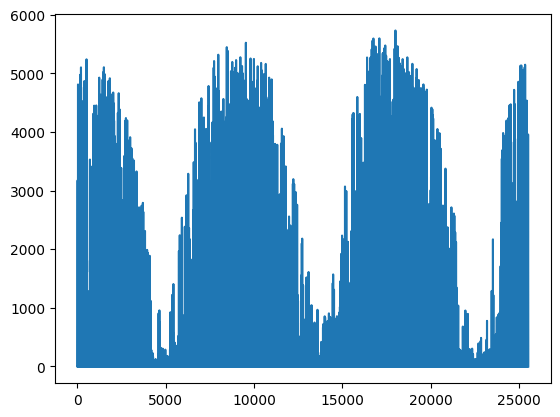

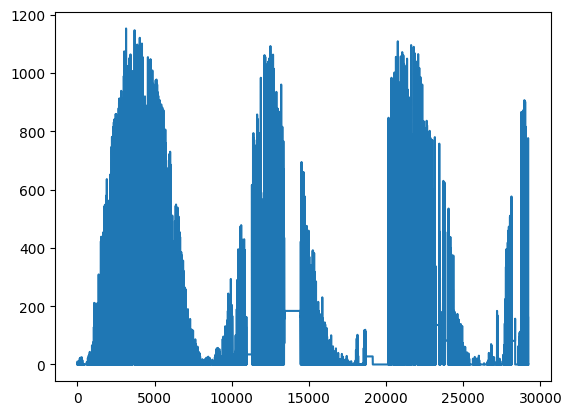

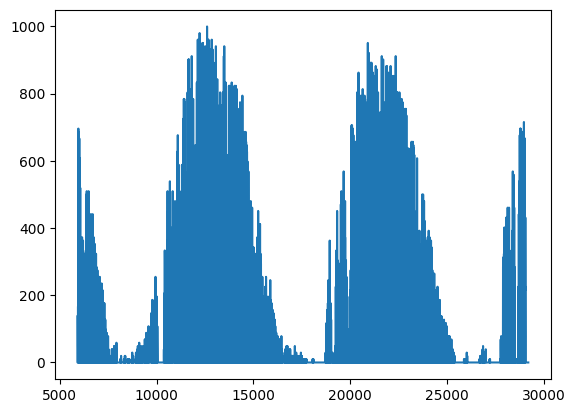

In [94]:
#C[0] = C[0][5800:]
#B[0].drop(index=B[0].iloc[13310:14560].index.tolist(), axis=0, inplace=True)

plt.plot(A[0]['pv_measurement'])
plt.show()
plt.plot(B[0]['pv_measurement'])
plt.show()
plt.plot(C[0]['pv_measurement'])


In [95]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [8, 9, 10, 11])

In [96]:
model_a = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner)
model_b = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner)
model_c = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner)

# Convert the dataset into a TensorFlow dataset.
train_ds_a = tfdf.keras.pd_dataframe_to_tf_dataset(A[0], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)
train_ds_b = tfdf.keras.pd_dataframe_to_tf_dataset(B[0], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)
train_ds_c = tfdf.keras.pd_dataframe_to_tf_dataset(C[0], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)

# Train a Random Forest model.
model_a.fit(train_ds_a)
model_b.fit(train_ds_b)
model_c.fit(train_ds_c)

Use /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmp7oejbzqp as temporary training directory
Use /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmpsa0g2er8 as temporary training directory
Use /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmpmu5tfw7a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.886418. Found 25537 examples.
Training model...


[INFO 23-11-06 14:00:07.7695 CET kernel.cc:1243] Loading model from path /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmp7oejbzqp/model/ with prefix f479a2af89e7455c


Model trained in 0:00:45.264368
Compiling model...


[INFO 23-11-06 14:00:08.6140 CET decision_forest.cc:660] Model loaded with 300 root(s), 349882 node(s), and 30 input feature(s).
[INFO 23-11-06 14:00:08.6141 CET abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-11-06 14:00:08.6141 CET kernel.cc:1075] Use fast generic engine


Model compiled.
Reading training dataset...
Training dataset read in 0:00:01.316420. Found 29222 examples.
Training model...


[INFO 23-11-06 14:01:45.5108 CET kernel.cc:1243] Loading model from path /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmpsa0g2er8/model/ with prefix 298f1843b6524d7a


Model trained in 0:01:36.318013
Compiling model...


[INFO 23-11-06 14:01:46.5759 CET decision_forest.cc:660] Model loaded with 300 root(s), 346922 node(s), and 41 input feature(s).
[INFO 23-11-06 14:01:46.5760 CET abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-11-06 14:01:46.5761 CET kernel.cc:1075] Use fast generic engine


Model compiled.
Reading training dataset...
Training dataset read in 0:00:01.777987. Found 23288 examples.
Training model...


[INFO 23-11-06 14:03:22.1155 CET kernel.cc:1243] Loading model from path /var/folders/lt/ffct_t4x1hq9sb2k_fhds_1w0000gp/T/tmpmu5tfw7a/model/ with prefix 42146cb12e9746bb


Model trained in 0:01:34.063677
Compiling model...


[INFO 23-11-06 14:03:23.0079 CET decision_forest.cc:660] Model loaded with 300 root(s), 290152 node(s), and 42 input feature(s).
[INFO 23-11-06 14:03:23.0080 CET abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-11-06 14:03:23.0080 CET kernel.cc:1075] Use fast generic engine


Model compiled.


In [97]:
#Plot models to file
tfdf.model_plotter.DisplayOptions(
    margin=10,
    node_x_size=160,
    node_y_size=28,
    node_x_offset=180,
    node_y_offset=33,
    font_size=10,
    edge_rounding=20,
    node_padding=2,
    show_plot_bounding_box=False
)

with open("model_a_plot.html", "w") as f:
    f.write(tfdf.model_plotter.plot_model(model_a))

with open("model_b_plot.html", "w") as f:
    f.write(tfdf.model_plotter.plot_model(model_b))

with open("model_c_plot.html", "w") as f:
    f.write(tfdf.model_plotter.plot_model(model_c))

In [98]:
validation_ds_a = tfdf.keras.pd_dataframe_to_tf_dataset(A[1], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)
validation_ds_b = tfdf.keras.pd_dataframe_to_tf_dataset(B[1], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)
validation_ds_c = tfdf.keras.pd_dataframe_to_tf_dataset(C[1], label='pv_measurement', task=tfdf.keras.Task.REGRESSION)

# Summary of the model structure.
#model_a.summary()
#model_b.summary()
#model_c.summary()

validation_a = model_a.predict(validation_ds_a)
validation_b = model_b.predict(validation_ds_b)
validation_c = model_c.predict(validation_ds_c)

actual_values_a = A[1]['pv_measurement']
actual_values_b = B[1]['pv_measurement']
actual_values_c = C[1]['pv_measurement']

print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_a, validation_a
)))
print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_b, validation_b
)))
print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_c, validation_c
)))

3/3 [==============================] - 0s 69ms/step
586.4613
81.14741
76.59617


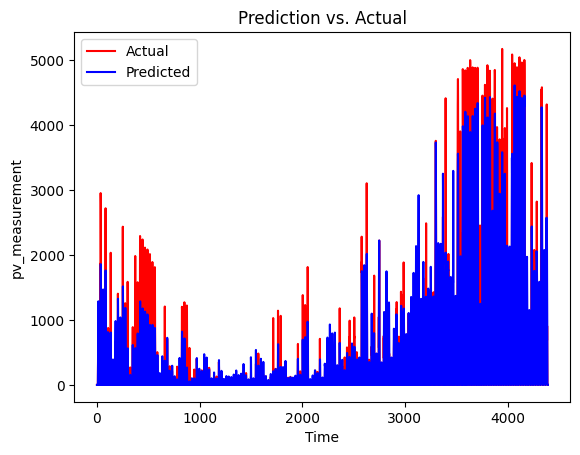

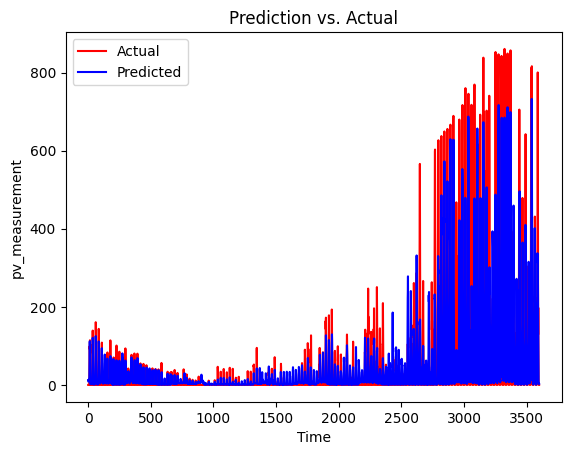

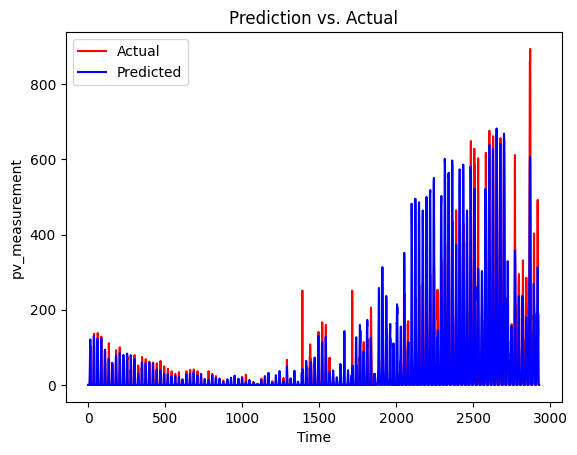

In [84]:
# Plotting Prediction vs. Actual
plt.plot(actual_values_a, label='Actual', color='red')
plt.plot(validation_a, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_b, label='Actual', color='red')
plt.plot(validation_b, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_c, label='Actual', color='red')
plt.plot(validation_c, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

In [61]:
#meta_X = np.column_stack((validation_a., validation_b, validation_c))
#meta_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
#meta_model.fit(meta_X, y)
#combined_predictions = meta_model.predict(meta_X)

In [62]:
test_ds_a = tfdf.keras.pd_dataframe_to_tf_dataset(A[2], task=tfdf.keras.Task.REGRESSION)
test_ds_b = tfdf.keras.pd_dataframe_to_tf_dataset(B[2], task=tfdf.keras.Task.REGRESSION)
test_ds_c = tfdf.keras.pd_dataframe_to_tf_dataset(C[2], task=tfdf.keras.Task.REGRESSION)

prediction_a = model_a.predict(test_ds_a)
prediction_b = model_b.predict(test_ds_b)
prediction_c = model_c.predict(test_ds_c)

submit = np.concatenate((np.concatenate((prediction_a, prediction_b)),prediction_c))

1/1 [==============================] - 0s 84ms/step


In [63]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [64]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [65]:
# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("random_forest_3.csv", index=False)

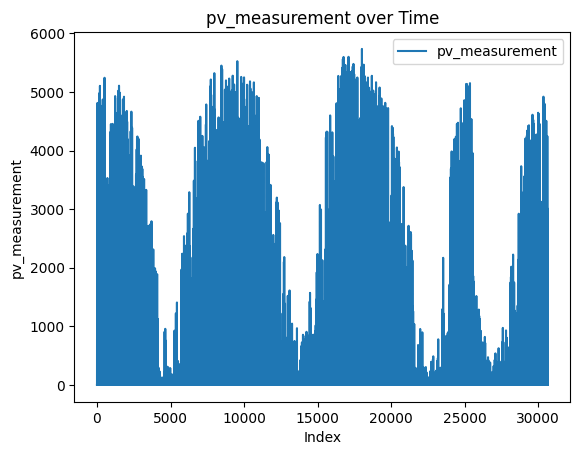

In [66]:
#Plot full sequence

pv_measurement_1 = A[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_a.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_a.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

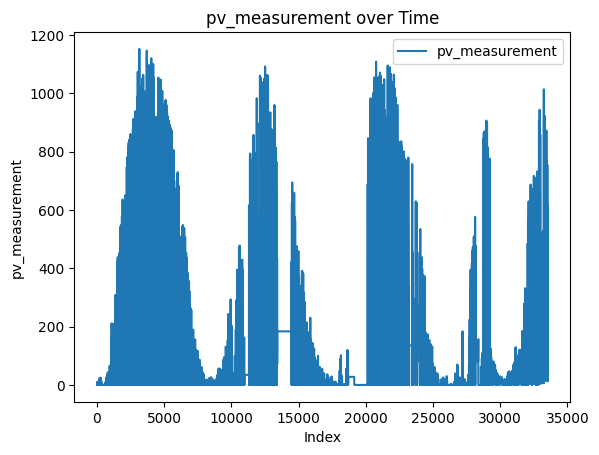

In [67]:
#Plot full sequence

pv_measurement_1 = B[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_b.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_b.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

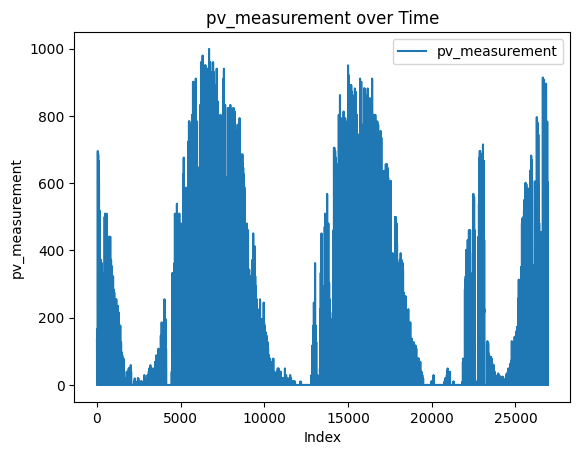

In [68]:
#Plot full sequence

pv_measurement_1 = C[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_c.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_c.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()